In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

import tqdm
import pickle

import uncertainties as uct
from uncertainties import unumpy as unp

from scipy.optimize import curve_fit

# 1. Inverting Amplifier

### 1.1 Transfer curve by frequencies

In [ ]:
# All resistances 

handle = open("inverting_amp_high.pkl", 'rb')
data_h=pickle.load(handle)
handle.close()

handle = open("inverting_amp_low.pkl", 'rb')
data_l=pickle.load(handle)
handle.close()

R1 = data_l["R1"]
freq = data_l["Freq"]
f = freq[6]

T, Ch1, Ch2 = data_l[f]
length = 100
T = T[:length]
Ch1 = Ch1[:length]
Ch2 = Ch2[:length]

fig = plt.figure(figsize=(8,8))
grid = gs.GridSpec(2,2,wspace=0.1,)

axs1 = plt.subplot(grid[0,0])
axs2 = plt.subplot(grid[0,1])
axs3 = plt.subplot(grid[1,:])

axs1.scatter(T,Ch1,s=0.3,color="orange")
axs2.scatter(T,Ch2,s=0.3,color="blue")
axs3.scatter(Ch1,Ch2,s=0.3)

### 1.2. Transfer curve by resistances

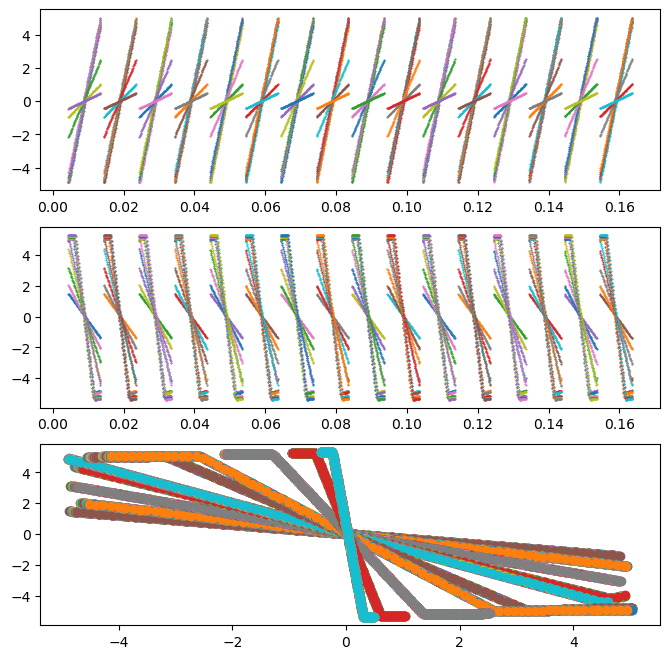

In [502]:
# Inverting amplifier time seires

def linear(x,a,b,c):
    return a*(x-b)+c

def fit(x,a,b,reg1,reg2):
    reg1,reg2 = int(reg1),int(reg2)
    V1 = linear(x[reg1],a,b)
    y1 = np.full(reg1,V1)
    y2 = linear(x[reg1:-reg2],a,b)
    V2 = linear(x[-reg2],a,b)
    y3 = np.full(reg2,V2)
    y = np.concatenate((y1,y2,y3))
    return y

########## End of Function Defining ##########

handle = open("inverting_amp.pkl", 'rb')
data=pickle.load(handle)
handle.close()

fig,axs = plt.subplots(3,1,figsize=(8,8))

axs1 = axs[0]
axs2 = axs[1]
axs3 = axs[2]

R1 = data["R1"]

for R2 in data["R2"]:
    T,Ch1,Ch2 = data[R2]

    amp = -R2/R1
    E_sat = 6
    freq = 100
    t_mes = 10/freq

    start = 36
    for i in range(1,17):
        # Remove all points created by the slewrate
        end = start+75
        t = T[start:end]; ch1 = Ch1[start:end]; ch2 = Ch2[start:end]
        start = end+7
        
        axs1.scatter(t,ch1,s=0.3)
        axs2.scatter(t,ch2,s=0.3)
        # X = np.linspace(-5,5,10)
        axs3.scatter(ch1,ch2)
        # start = 36*(i+1); end = 53*(i+2)
        

c:\ProgramData\anaconda3\envs\yeerum\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


-0.29998897490510734
[5.39985571e-05 3.11923453e-04]
-0.42910319278654896
[9.40446634e-05 3.58793042e-04]
-0.6411263971298311
[6.62285309e-05 3.23397719e-04]
-0.9068023183471475
[0.00121915 0.0021539 ]
-0.9969232775561022
[0.00020943 0.00101121]
-1.6431407399007834
[0.00308559 0.02900505]
-1.8155444430319096
[0.00439481 0.03254356]
-3.741440290902304
[0.00775329 0.03401478]
-8.985396870150218
[0.00864622 0.03511666]
-19.25940932917781
[0.04401674 0.03201368]


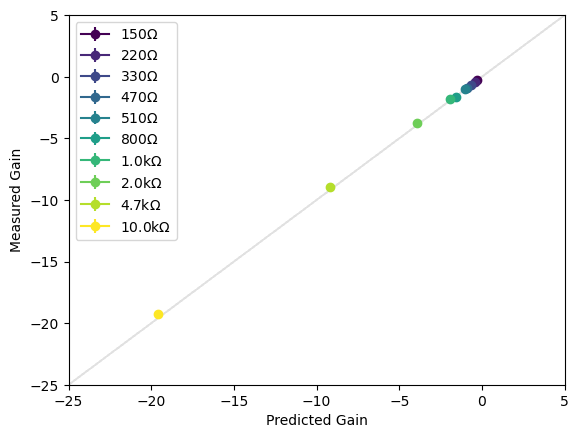

In [10]:
def linear(x,a,b):
    return a*x+b

def fit(x,a,b,reg):
    reg = int(reg)
    V1 = linear(x[reg],a,b)
    y1 = np.full(reg,V1)
    y2 = linear(x[reg:-reg],a,b)
    V2 = linear(x[-reg],a,b)
    y3 = np.full(reg,V2)
    y = np.concatenate((y1,y2,y3))
    return y

########## End of Function Defining ##########

handle = open("inverting_amp.pkl", 'rb')
data=pickle.load(handle)
handle.close()

colours = plt.cm.viridis(np.linspace(0, 1, len(data["R2"])))
R1 = data["R1"]

m_values = []
for i, R2 in enumerate(data["R2"]):
    _,Ch1,Ch2 = data[R2]
    
    amp = -R2/R1
    E_sat = 6

    param = []
    start = 36
    for cycle in range(1,17):
        # Remove all points created by the slewrate
        end = start+75
        ch1 = Ch1[start:end]; ch2 = Ch2[start:end]
        start = end+7
        
        # Sort time series by increasing Ch1 values. 
        indices = np.argsort(ch1) 
        ch1 = ch1[indices]
        ch2 = ch2[indices]
    
        label = fr"{R2/1000}k$\Omega$" if R2 >= 1000 else fr"{R2}$\Omega$"
        # plt.scatter(ch1,ch2
        #              ,s=0.5,alpha=0.6,color=colours[i]
        #              )
    
        trial = [amp,25e-6,1]
        if R2 >= 800:
            trial = [amp,25e-6,15]
        popt,_ = curve_fit(fit,ch1,ch2,p0=trial,maxfev = 10800)
        param.append(popt[:2])
    err = np.std(param,axis=0)
    param = np.mean(param,axis=0)
    print(param[0])
    print(err)
    
    X = np.linspace(-25,5)
    plt.plot(X,X,color="black",alpha=0.01)
    plt.errorbar(amp,param[0]
                  ,label=label
                  ,yerr = err[0]
                  ,marker = "o"
                  ,color = colours[i]
                  )
# plt.ylim(-6,6); plt.xlim(-5.5,5.5)
# plt.grid()
# plt.ylabel("Output Voltage (V)")
# plt.xlabel("Input Voltage (V)")

plt.ylim(-25,5); plt.xlim(-25,5)
plt.legend(loc="upper left")
plt.ylabel(r"Measured Gain")
plt.xlabel(r"Predicted Gain")

plt.savefig("figures/inverting_slopesB.png")

# Individual NICs

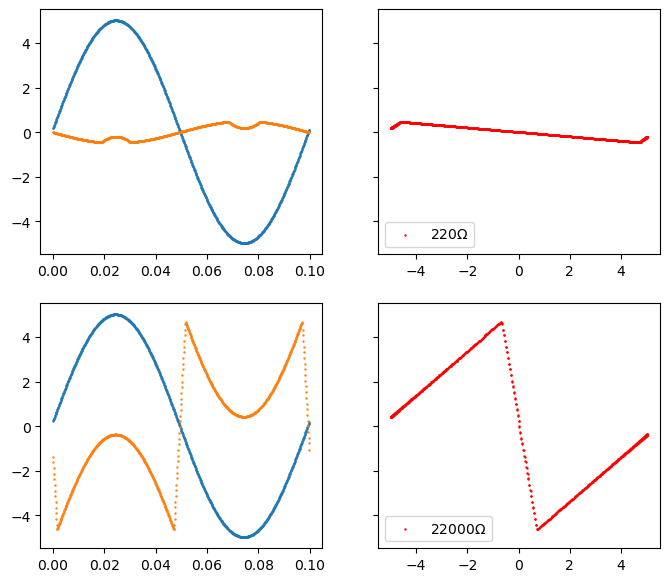

In [4]:
fig,axs = plt.subplots(2,2,figsize=(8,7),sharey="row")

handle = open("NIC_transfer_curve.pkl", 'rb')
data=pickle.load(handle)
handle.close()

for i,R_i in enumerate([data["Res"][0],data["Res"][3]]):
    ax = axs[i]
    T,Ch1,Ch2 = data[R_i]
    
    fraction = round(len(T)/10) # Data points in one oscillation
    T = T[:fraction]; Ch1 = Ch1[:fraction]; Ch2 = Ch2[:fraction]
    
    ax[0].scatter(T,Ch1,s=0.5)
    ax[0].scatter(T,Ch2,s=0.5)
    ax[1].scatter(Ch1,Ch2,label=fr"{R_i}$\Omega$",s=0.5,color="red")
    ax[1].legend(loc="lower left")

220 220 2200
Theory [-0.44905149789776705, 4.545454545454545, 5.460545454545454] 
 Fit [-0.4525136   3.33378381  4.63579955] [0.00013951 0.00678602 0.00047227]
22000 22000 3300
Theory [-0.30037891318076565, 0.04545454545454545, 0.7886086956521738] 
 Fit [-0.30399154  0.04506428  0.69672517] [1.50870968e-04 2.77465448e-06 2.96047581e-04]


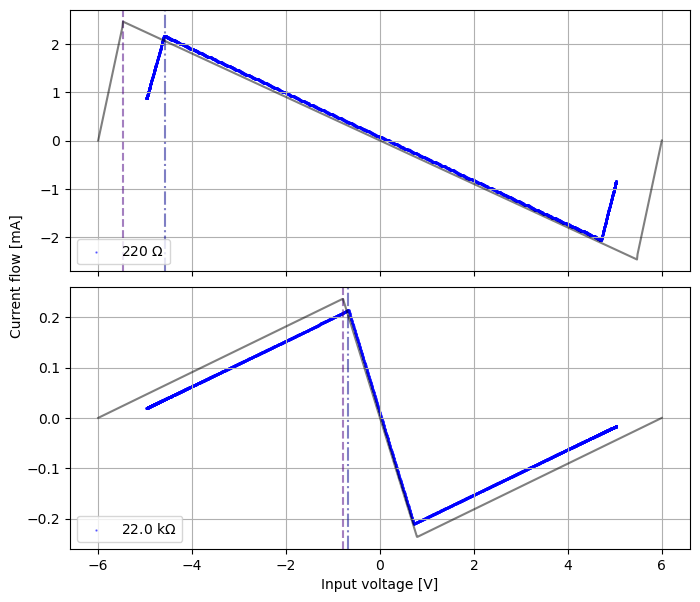

In [4]:
# Fitting 
def linear(x,a,b,c):
    return a*(x-b)+c

def fit(x,aint,aext,b,reg):
    reg = int(reg)
    c = b*aint
    y1 = linear(x[:reg],aext,-b,-c)
    y2 = linear(x[reg:-reg],aint,b,c)
    y3 = linear(x[-reg:],aext,b,c)

    return np.concatenate((y1,y2,y3))

########## End of Function Defining ##########

fig,axs = plt.subplots(2,1,figsize=(8,7),sharex=True)#,sharey=True)
fig.subplots_adjust(hspace=0.06)

handle = open("NIC_transfer_curve.pkl", 'rb')
data=pickle.load(handle)
handle.close()

Vcc = data["Vcc"][0]
A = 1000

for i,R_i in enumerate([data["Res"][0],data["Res"][3]]):
    ax = axs[i]
    ax.grid()
    T,Ch1,Ch2 = data[R_i]
    Ch2 /= R_i/1000 # Convert to mA from the start to avoid headaches
    fraction = round(len(T)/10)

    # Split time series by cycle and fit PER cycle for error analysis.
    param = [] # Fitted parameters
    for cycle in range(10):
        start = cycle*fraction
        final = (cycle+1)*fraction
        t = T[start:final]; ch1 = Ch1[start:final]; ch2 = Ch2[start:final]
        
        # Sort time series by increasing Ch1 values. 
        indices = np.argsort(ch1)
        ch1 = ch1[indices]; ch2 = ch2[indices]

        if i==0:
            R1,R2,R3 = data["Res"][:3]
            reg = round(len(t)/8)
        else: 
            R1,R2,R3 = data["Res"][3:]
            reg = round(len(t)/2.2)
        m_ext = 1/R1*1000
        m_int = ((1-A)*R2+R3)/(R1*(R2+(1+A)*R3))*1000
        # m_int= -R2/R1/R3
        b = (R2+(1+A)*R3)/(A*(R2+R3))*Vcc
        # b = R3/(R2+R3)*Vcc

        trial = [m_int,m_ext,b,reg]
        popt,_ = curve_fit(fit,ch1,ch2,p0=trial,maxfev = 2800)
        param.append(popt)
    popt = np.mean(param,axis=0)
    err = np.std(param,axis=0)
    print(R1,R2,R3)
    print("Theory",trial[:3],"\n Fit",popt[:3],err[:3])

    X = np.linspace(-6,6,1000)
    split = int((6-b)/12*1000)
    ax.axvline(x=X[split],ls="dashed",color="indigo",alpha=0.5)
    ax.axvline(x=ch1[reg],ls="dashdot",color="darkblue",alpha=0.5)

    ax.plot(X,fit(X,*trial[:3],split),alpha=0.5,color="black")

    # X_exp = np.concatenate([np.linspace(-6,ch1[reg-1],100)
    #                     ,ch1
    #                     ,np.linspace(ch1[-reg+1],6,100)]
    #                     )

    # ax.scatter(X_exp,fit(X_exp,*popt[:3],reg+100),color="black",alpha=0.5,s=0.4)
    label = fr"{R_i/1000} k$\Omega$" if R_i==22000 else fr"{R_i} $\Omega$"
    ax.scatter(Ch1,Ch2,label=label,s=0.5,alpha=0.5,color="blue")
    ax.legend(loc="lower left")
axs[1].set_xlabel("Input voltage [V]")
fig.text(0.05, 0.5, 'Current flow [mA]', va='center', rotation='vertical')
fig.savefig("../figures/NIC_curve.png")

Error 220 [0.0000000e+00 8.8817842e-16 0.0000000e+00 0.0000000e+00]
Error 22000 [5.55111512e-17 6.93889390e-18 1.11022302e-16 0.00000000e+00]
[-0.44905149789776705, 4.545454545454546, 5.460545454545454, 102.0] 
 [-0.3003789131807656, 0.045454545454545456, 0.788608695652174, 372.0]
44 434


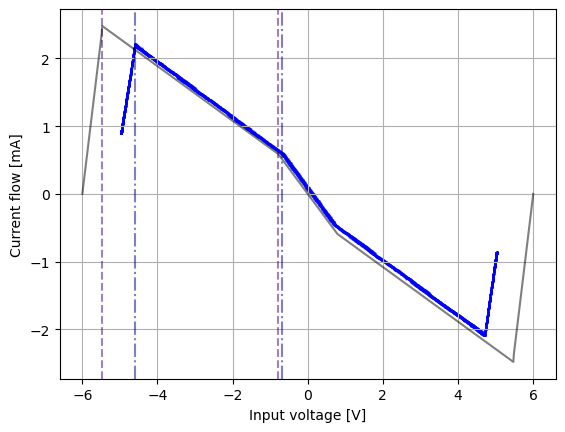

In [10]:
# Fitting 
def linear(x,a,b,c):
    return a*(x-b)+c

def fit(x,aint,aext,b,reg):
    reg = int(reg)
    c = b*aint
    y1 = linear(x[:reg],aext,-b,-c)
    y2 = linear(x[reg:-reg],aint,b,c)
    y3 = linear(x[-reg:],aext,b,c)

    return np.concatenate((y1,y2,y3))

########## End of Function Defining ##########

handle = open("NIC_transfer_curve.pkl", 'rb')
data=pickle.load(handle)
handle.close()

Vcc = data["Vcc"][0]
A = 1000

# Create empty arrays onto which each NIC will be added. 
T = np.full(len(data[220][0]),0.)
Ch1 = data[220][1]
Ch2 = np.full(len(data[220][0]),0.)

for R_i in [data["Res"][0],data["Res"][3]]:
    t,ch1,ch2 = data[R_i]
    T += t
    Ch2 += ch2/R_i*1000 # Convert to mA

plt.scatter(Ch1,Ch2,s=0.5,alpha=0.5,color="blue")
plt.grid()

param = []
for i,R_i in enumerate([data["Res"][0],data["Res"][3]]):
    T,Ch1,Ch2 = data[R_i]
    Ch2 /= R_i/1000 # Convert to mA from the start to avoid headaches
    fraction = round(len(T)/10)

    # Split time series by cycle and fit PER cycle for error analysis.
    trial = []
    for cycle in range(10):
        start = cycle*fraction
        final = (cycle+1)*fraction
        t = T[start:final]; ch1 = Ch1[start:final]; ch2 = Ch2[start:final]
        
        # Sort time series by increasing Ch1 values. 
        indices = np.argsort(ch1)
        ch1 = ch1[indices]; ch2 = ch2[indices]

        if i==0:
            R1,R2,R3 = data["Res"][:3]
            reg = round(len(t)/8)
        else: 
            R1,R2,R3 = data["Res"][3:]
            reg = round(len(t)/2.2)
        m_ext = 1/R1*1000
        m_int = ((1-A)*R2+R3)/(R1*(R2+(1+A)*R3))*1000
        b = (R2+(1+A)*R3)/(A*(R2+R3))*Vcc

        trial.append([m_int,m_ext,b,reg])
    param.append([i for i in np.mean(trial,axis=0)])
    print("Error",R_i,np.std(trial,axis=0))

    plt.axvline(x=ch1[reg],ls="dashdot",color="darkblue",alpha=0.5)

print(param[0],"\n",param[1])
X = np.linspace(-6,6,1000)
b1,b2 = param[0][2], param[1][2]
split1,split2 = int((6-b1)/12*1000),int((6-b2)/12*1000)
print(split1,split2)

plt.axvline(x=X[split1],ls="dashed",color="indigo",alpha=0.5)
plt.axvline(x=X[split2],ls="dashed",color="indigo",alpha=0.5)

plt.plot(X
         ,fit(X,*unp.nominal_values(param[0][:3]),split1)\
            +fit(X,*unp.nominal_values(param[1][:3]),split2)
            ,alpha=0.5,color="black")

plt.xlabel("Input voltage [V]"); plt.ylabel('Current flow [mA]')

plt.savefig("../figures/Chua_characteristic.png")
